# Module 1. Training from Local Environment using GluonTS
---

본 모듈에서는 GluonTS를 사용하여 시계열 데이터에 대한 훈련 및 추론을 수행해 보겠습니다.
노트북 실행에는 2~3분 소요되지만, 핸즈온 실습 시에는 25분을 권장드립니다. 특히 시계열 데이터, pandas, GluonTS를 다루는 데 익숙하지 않으면 각 코드 셀별로 실행시켜 보시는 것을 추천드립니다.

이 데이터셋은 10개의 상점, 50개의 아이템으로 **일단위** 판매 수량을 예측하는 데이터셋입니다.
별도의 아이템 메타데이터나 연관 시계열 데이터가 없는 가장 간단한 데이터로, `related time series` 및 `item metadata` 없이 `target time series`만으로 훈련 및 예측을 수행하게 됩니다.

### References
- Dataset description: https://www.kaggle.com/c/demand-forecasting-kernels-only/overview 
- Amazon Forecast 핸즈온: https://github.com/chrisking/ForecastPOC
- Amazon Forecast 핸즈온(한국어): https://github.com/gonsoomoon-ml/Forecast/tree/master/StoreItemDemand
- GluonTS: https://ts.gluon.ai/

## 1. Setup
---
만약 GluonTS가 인스톨되어 있지 않다면, 아래 코드 셀의 주석을 해제하고 코드 셀을 실행시켜 주세요.

In [1]:
# !pip install -qU gluonts==0.6.7

### Import Libraries
표준 Python 라이브러리를 가져옵니다.

In [2]:
import os
import pandas as pd
import gluonts 
import numpy as np
import argparse
import json
import pathlib
import mxnet as mx
from mxnet import gpu, cpu
from mxnet.context import num_gpus
import matplotlib.pyplot as plt

from gluonts.dataset.util import to_pandas
from gluonts.mx.distribution import DistributionOutput, StudentTOutput, NegativeBinomialOutput, GaussianOutput
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions, backtest_metrics
from gluonts.model.predictor import Predictor
from gluonts.dataset.field_names import FieldName
from gluonts.dataset.common import ListDataset

<br>

## 2. Data Loading & Checking
---

판매 데이터를 판다스 데이터프레임으로 로딩합니다. 데이터프레임 로딩 후, 날짜 컬럼을 `datetime` 포맷의 컬럼으로 변경합니다. 본 예제는 데이터 사이즈가 크지 않기에 차이를 느끼기 어렵겠지만, 수천 만개의 행을 그대로 `datetime` 으로 변환하면 모든 행을 순회해야 하기에 시간이 오래 소요됩니다. 따라서, 고유한 날짜만 `datetime`으로 변환하여 `map()`으로 그룹 매핑하면 빠르게 변환할 수 있습니다.

In [3]:
data_dir = 'data'
data_file_name = 'train.csv'

df = pd.read_csv(os.path.join(data_dir, data_file_name))
date_cache = {k: pd.to_datetime(k) for k in df['date'].unique()}
df['date'] = df['date'].map(date_cache)
df.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


매장별 총 판매 수량을 확인합니다.

In [4]:
sales_cnt = df.groupby('store')['sales'].agg(['sum'])
sales_cnt = sales_cnt.sort_values(by=['sum'], ascending=False)
sales_cnt

,sum
store,
2,6120128
8,5856169
3,5435144
10,5360158
9,5025976
4,5012639
1,4315603
5,3631016
6,3627670


<br>

## 3. Data Wrangling
---

Amazon Forecast는 csv 파일을 입력데이터로 지원하지만, 대부분의 경우 raw 데이터를 그대로 사용할 수 없습니다. Forecast 뿐만 아니라, SageMaker built-in DeepAR이나 GluonTS도 마찬가지이므로 전처리 작업은 필수입니다. 대표적인 데이터 전처리 예시들은 아래와 같습니다.

- 중복 제거
- 이상치 제거 or padding (예: 수량 예측 시 0보다 작은 값이 포함된 경우 0으로 padding)
- Daily/Weekly Aggregation (Mean, Sum, Min, Max 등)
- Missing date padding 
- Missing data imputation
- 범주형 데이터의 label ncoding, one-hot encoding

본 데이터셋은 이미 정제가 되어 있기 때문에 전처리가 필요없으며, 전처리 예제는 다른 예제들을 참고하시면 됩니다.

### 날짜 범위 지정

데이터셋의 날짜 범위를 지정합니다.

In [5]:
FREQ = 'D'
start_dt, end_dt = df['date'].agg(['min', 'max'])
dt_index = pd.date_range(start_dt, end_dt, freq=FREQ)

In [6]:
start_train_date = '2015-01-01' 
end_train_date = '2017-12-01' 
end_val_date = '2018-01-01' 

### Aggregation and unstack

문제를 간소화하기 위해 모든 상점에 대한 판매 수량을 합산 후, `unstack()`으로 GlounTS의 Dataset에 적합한 형태인 `(num_timesteps x num_series)` 형태로 변환합니다.
- num_timesteps: Timesteps
- num_series: 샘플 개수 (만약 하나의 시계열만 가지고 있다면 num_series = 1입니다.)


만약 데이터셋에 결측 시계열이 포함되어 있는 경우 `pd.MultiIndex.from_product()`로 모든 시계열에 대한 경우의 수를 체크하고 `reindex()`로 재인덱싱 후, backward fill/forward fill로 결측 시계열을 채워 주시는 것을 권장드립니다.

In [7]:
target_col = 'sales'
df_agg = df.groupby(['item', 'date'])[[target_col]].mean()
target_df = df_agg[target_col].unstack('item')

In [8]:
target_df.head()

item,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
date,,,,,,,,,,,,,,,,,,,,,
2013-01-01,13.3,32.7,17.2,10.2,8.3,28.8,27.8,41.6,24.5,37.8,...,10.3,19.5,25.3,15.4,39.6,31.9,11.6,27.7,15.9,33.0
2013-01-02,9.9,27.9,21.3,11.0,8.1,31.0,29.1,38.6,22.5,39.7,...,13.2,21.5,25.5,16.5,39.3,31.6,11.8,28.1,15.9,38.4
2013-01-03,12.7,30.4,19.3,11.2,9.6,30.9,32.4,39.8,26.5,38.8,...,13.1,21.5,30.6,17.0,45.9,32.5,10.4,28.0,18.7,35.6
2013-01-04,14.5,35.9,21.8,13.8,10.8,34.3,33.5,43.0,31.3,46.2,...,12.2,22.4,32.3,18.9,45.0,35.1,12.8,29.6,18.4,39.4
2013-01-05,14.9,37.7,21.7,14.4,10.0,34.3,37.7,48.1,31.9,44.9,...,14.2,24.3,30.9,20.2,53.3,36.0,13.3,34.4,17.9,40.7


전처리가 완료된 데이터를 다음 모듈에서 그대로 활용하기 위해 csv로 저장합니다.

In [9]:
target_df.to_csv(f'./{data_dir}/target_train.csv')

<br>

## 4. Preparing GlounTS Dataset
---


In [11]:
num_steps, num_series = target_df.shape
target = target_df.values
pred_length = 28
custom_ds_metadata = {'num_series': num_series,
                      'num_steps': num_steps,
                      'prediction_length': pred_length,
                      'freq': FREQ,
                      'start': [start_dt for _ in range(num_series)] 
                     }

### Create GluonTS Dataset

GluonTS Dataset을 생성하기 위해서는 `FieldName.TARGET`과 `FieldName.START` 키에 해당하는 값들이 반드시 포함되어야 하며, 나머지 FieldName에 대해서는 선택적으로 포함할 수 있습니다.
 
그리고, 일반적인 ML 알고리즘과 달리 GlounTS의 테스트 데이터셋은 훈련 데이터 전부를 포함합니다.
예를 들어 100일치 시계열을 대상으로, 마지막 20일치 데이터에 대해 테스트가 필요한 경우(80일 훈련, 20일 테스트), 
시작일부터 80일치까지의 시계열을 훈련 데이터로 지정하고 100일치의 모든 데이터를 그대로 테스트 데이터셋으로 지정하시면 됩니다. 전체 시계열이 필요한 이유는
Evaluator 클래스를 통해 metric 및 plotting을 한 줄의 코드로 간단하게 수행하기 위함이고, 실제 내부 로직에서는 테스트 시계열에서 예측 시계열 길이만큼의(예: 20일치) 데이터를 잘라내어 추론을 수행합니다.

In [12]:
train_lst = []
for i in range(0, num_series):
    target_vec = target[:-pred_length, i]
    dic = {FieldName.TARGET: target_vec, 
           FieldName.START: start_dt} 

    train_lst.append(dic)
    
test_lst = []
for i in range(0, num_series):
    target_vec = target[:, i]
    dic = {FieldName.TARGET: target_vec, 
           FieldName.START: start_dt} 
    test_lst.append(dic)

train_ds = ListDataset(train_lst, freq=FREQ)
test_ds = ListDataset(test_lst, freq=FREQ)    

<br>

## 5. Baseline Training and Evaluation (Seasonal naïve)
---

머신러닝의 첫번째 iteration은 baseline 모델을 만들어 보는 것입니다. baseline을 통해 모델이 예측하는 하한선(lower bound)을 알 수 있으며, 특히 복잡한 패턴들이 많은 시계열 데이터에서는 baseline이 매우 잘 동작합니다. 

Seasonal naïve는 이전 데이터의 통계치를 반영하는 모델로, 과거 관측치를 복사하기 때문에 복잡한 훈련 과정 수행 없이 곧바로 추론이 가능하다는 장점이 있습니다.

In [13]:
from gluonts.model.seasonal_naive import *
from gluonts.evaluation import Evaluator

naive_predictor = SeasonalNaivePredictor(freq=FREQ, 
                                         prediction_length=pred_length,
                                         season_length=300)

### Evaluation

In [14]:
forecast_it_baseline, ts_it_baseline = make_evaluation_predictions(test_ds, naive_predictor, num_samples=100)
forecasts_baseline = list(forecast_it_baseline)
tss_baseline = list(ts_it_baseline)

In [15]:
from pylab import rcParams
from itertools import islice
from gluonts.evaluation.backtest import make_evaluation_predictions

rcParams['figure.figsize'] = 15, 8
    
def plot_forecasts(tss, forecasts, past_length=40, num_plots=2):
    for target, forecast in islice(zip(tss, forecasts), num_plots):
        ax = target[-past_length:].plot(figsize=(12, 5), linewidth=2)
        forecast.plot(color='g')
        plt.grid(which='both')
        plt.legend(["observations", "median prediction", "90% confidence interval", "50% confidence interval"])
        plt.show()
        
        
def get_metrics(tss, forecasts, num_series, verbose=1):
    evaluator = Evaluator(num_workers=os.cpu_count())
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=num_series)
    metrics = ['RMSE', 'MAPE', 'wQuantileLoss[0.1]', 'wQuantileLoss[0.5]', 'wQuantileLoss[0.9]', 'mean_wQuantileLoss']
    metrics_dic = dict((key,value) for key, value in agg_metrics.items() if key in metrics)
    if verbose == 1:
        print(json.dumps(metrics_dic, indent=4))
    return metrics_dic

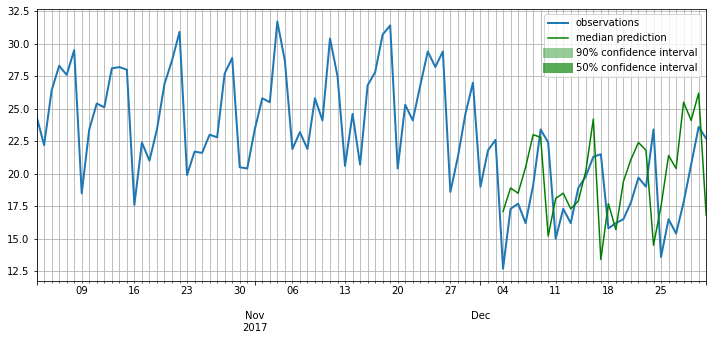

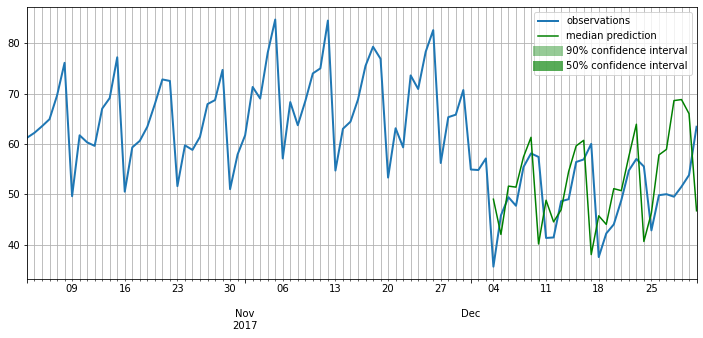

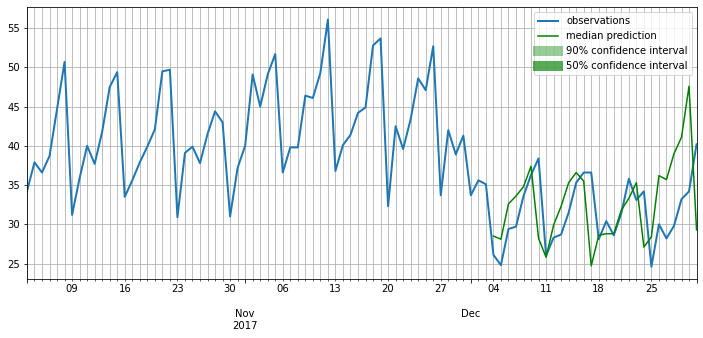

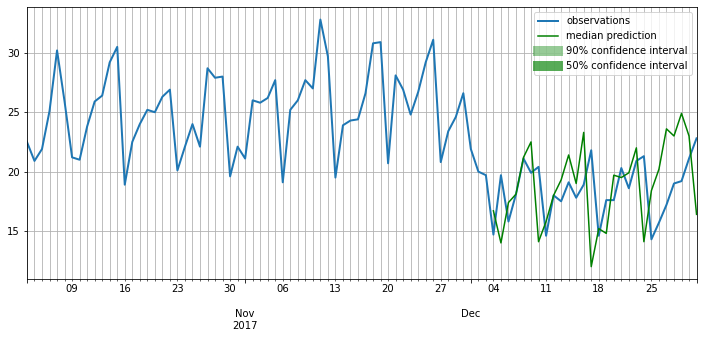

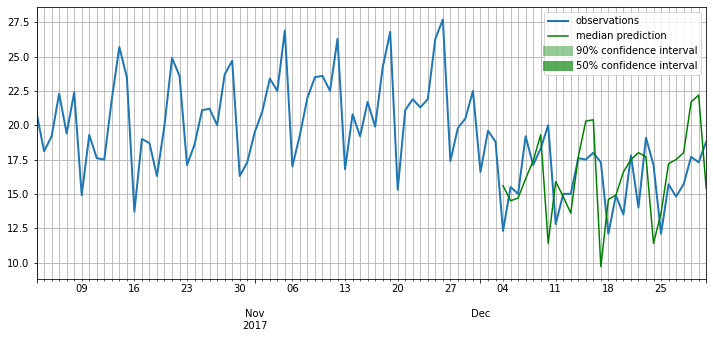

In [16]:
plot_forecasts(tss_baseline, forecasts_baseline, past_length=90, num_plots=5)

In [17]:
metrics_baseline = get_metrics(tss_baseline, forecasts_baseline, len(test_ds))

Running evaluation: 100%|██████████| 50/50 [00:00<00:00, 744.43it/s]


{
    "MAPE": 0.1568066139370803,
    "RMSE": 9.457051060131858,
    "wQuantileLoss[0.1]": 0.18990814056905686,
    "wQuantileLoss[0.5]": 0.15479852099379762,
    "wQuantileLoss[0.9]": 0.11968890141853841,
    "mean_wQuantileLoss": 0.15479852099379762
}


<br>

## 6. Training and Evaluation (DeepAR)
---

DeepAR로 예측을 수행해 보겠습니다. DeepAR의 자세한 기술적인 내용은 아래 논문을 참조하세요.

Reference: https://arxiv.org/abs/1704.04110

### Training

In [18]:
device = 'gpu' if num_gpus() > 0 else "cpu"
trainer = Trainer(
    ctx=device,
    epochs=20,
    learning_rate=0.001,
    batch_size=32
)

In [19]:
deepar_estimator = DeepAREstimator(freq=FREQ, 
                                   prediction_length=pred_length,
                                   num_cells=30,
                                   distr_output=StudentTOutput(),
                                   trainer=trainer)

In [20]:
deepar_predictor = deepar_estimator.train(train_ds)

  0%|          | 0/50 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:02<00:00, 20.63it/s, epoch=20/20, avg_epoch_loss=2.35]


### Evaluation

아래 코드 셀에서는 `gluonts.evaluation.Evaluator()`를 사용하여 훈련된 모델의 지표(metirc)들을 생성합니다. 지표들은
딕셔너리와 판다스 데이터프레임의 두 가지 형태들로 반환하며, Evaluator 생성자 호출 시에 필요한 지표들만 명시적으로 지정할 수도 있습니다. 

참고로, 딥러닝 기반 모델은 점예측이 아닌 모수 예측을 통한 샘플링이기 때문에 `make_evaluation_predictions` 함수의 `num_samples`는 자유롭게 부여하시면 됩니다.

In [21]:
%%time
forecast_it, ts_it = make_evaluation_predictions( 
                     dataset=test_ds,  # test dataset
                     predictor=deepar_predictor, # predictor
                     num_samples=100) # number of sample paths we want for evaluation
forecasts = list(forecast_it)
tss = list(ts_it)

CPU times: user 809 ms, sys: 100 ms, total: 909 ms
Wall time: 557 ms


In [22]:
evaluator = Evaluator()
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))

Running evaluation: 100%|██████████| 50/50 [00:00<00:00, 183.91it/s]


### Plotting

5가지 아이템에 대해서 28일치 예측 결과를 출력해 보겠습니다.

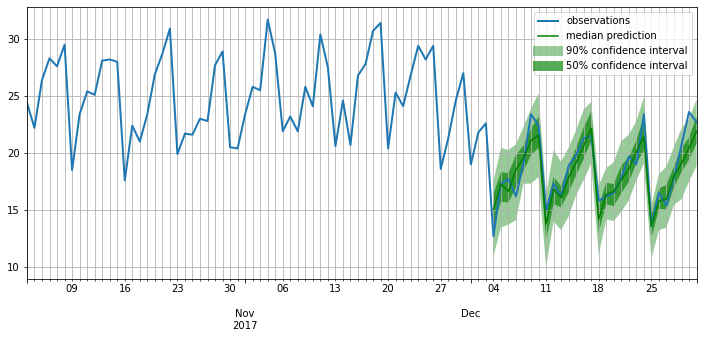

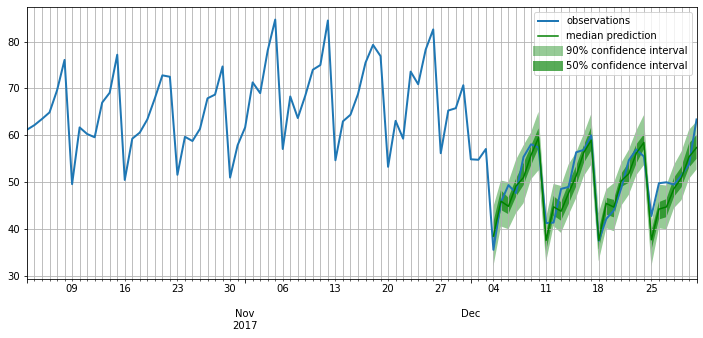

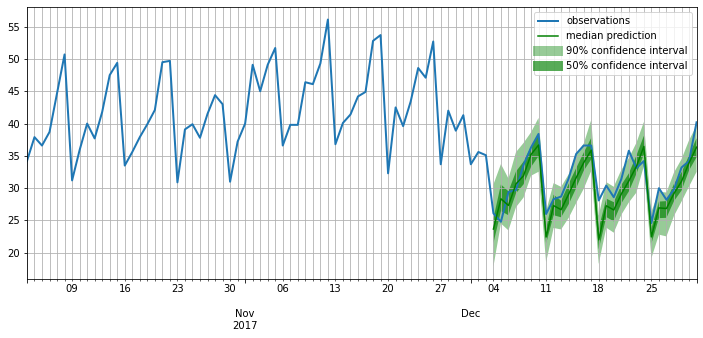

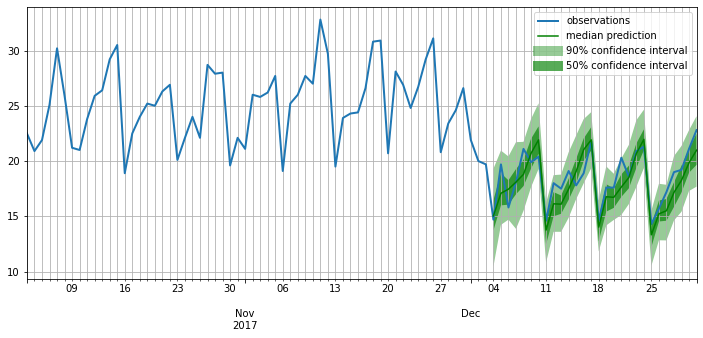

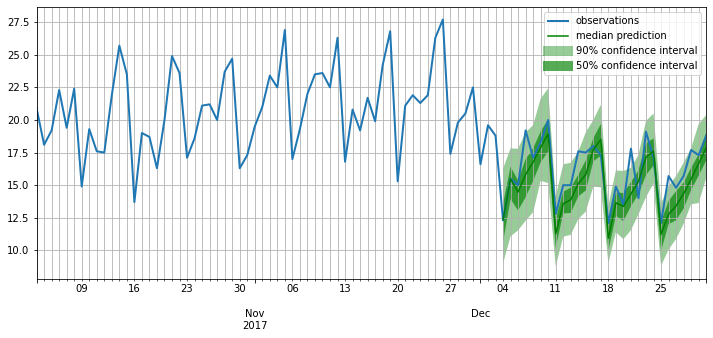

In [23]:
plot_forecasts(tss, forecasts, past_length=90, num_plots=5)

In [24]:
metrics = get_metrics(tss, forecasts, len(test_ds))

Running evaluation: 100%|██████████| 50/50 [00:00<00:00, 194.34it/s]


{
    "MAPE": 0.05086978326728816,
    "RMSE": 2.672255148044503,
    "wQuantileLoss[0.1]": 0.021954946029455722,
    "wQuantileLoss[0.5]": 0.04713458007262408,
    "wQuantileLoss[0.9]": 0.02061091467369247,
    "mean_wQuantileLoss": 0.03677197417697311
}


### Compare with two models

Baseline 모델과 DeepAR 모델의 성능을 확인해 보겠습니다.

In [25]:
metrics_df = pd.concat([pd.Series(metrics_baseline), pd.Series(metrics)], axis=1)
metrics_df.columns=['Baseline', 'DeepAR']
display(metrics_df)

,Baseline,DeepAR
MAPE,0.156807,0.050870
RMSE,9.457051,2.672255
wQuantileLoss[0.1],0.189908,0.021955
wQuantileLoss[0.5],0.154799,0.047135
wQuantileLoss[0.9],0.119689,0.020611
mean_wQuantileLoss,0.154799,0.036772


<br>

## 7. Miscellaneous
---

### Save the model

모델을 저장합니다. 저장된 모델은 deserialize하여 로딩 가능합니다.

In [26]:
model_dir = 'model'
!rm -rf $model_dir
os.makedirs(model_dir, exist_ok=True)
deepar_predictor.serialize(pathlib.Path(model_dir))

### Inference

모델 배포 이후 추론을 수행하는 간단한 예시입니다. `make_evaluation_predictions()` 대신 `predict()` 를 사용하세요.

In [27]:
target_test_df = target_df.iloc[pred_length:,:]
target_test_df.set_index(target_test_df.columns[0], inplace=True)
n = 10
target_test_df = target_test_df.iloc[pred_length:,:n]

In [28]:
target = target_test_df.values
num_series = target_test_df.shape[1]
start_dt = target_test_df.index[0]
test_lst = []
for i in range(0, num_series):
    target_vec = target[:, i]
    dic = {FieldName.TARGET: target_vec, 
           FieldName.START: start_dt} 
    test_lst.append(dic)
test_ds = ListDataset(test_lst, freq='1D')

In [29]:
forecast_it = deepar_predictor.predict(test_ds)
forecasts = list(forecast_it)
predictions = [list(f.samples.mean(axis=0)) for f in forecasts]
response_body = json.dumps({'predictions': str(predictions)})